In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from lib.tes import *

plt.rcParams['font.family'] = 'Times New Roman'
coefs_mmd = [0.9950, 0.7264, 0.8002] # calibrated by JPL for 5-band TES

# display the atmospheric profile dataset and spectra library

In [2]:
# Fig 1: distribution of profiles
lat, lon = np.load('data/profile_info/lat.npy'), np.load('data/profile_info/lon.npy')
idx_clear = np.load('data/profile_info/idx_clear.npy')
lat, lon = lat[idx_clear], lon[idx_clear]

tpw = np.load('data/simulation_dataset/tpw.npy')
skt = np.load('data/simulation_dataset/skt.npy')

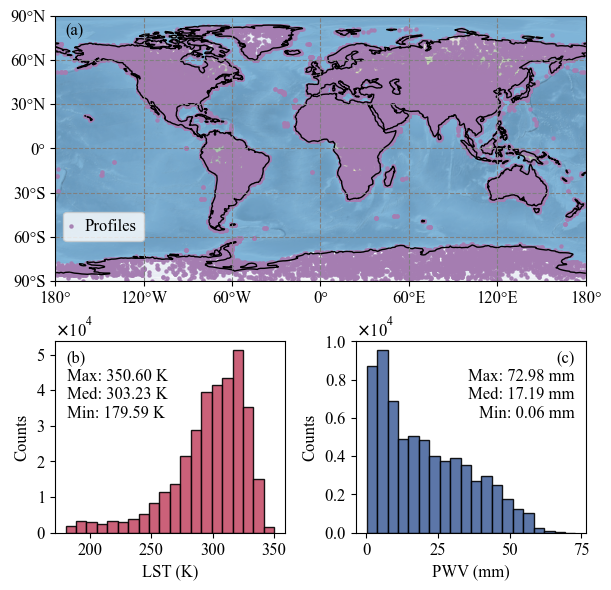

In [5]:
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import ScalarFormatter
plt.rcParams['font.size'] = 12

fig = plt.figure(layout="constrained", figsize=(6, 6))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 0.6])

# subplot 1
ax = plt.subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.scatter(lon, lat, s=5, c='#A57DB1', alpha=0.9)
ax.stock_img() # add background color
ax.coastlines()
ax.gridlines(linestyle='--', color='gray')
ax.legend(['Profiles'], loc='lower left', bbox_to_anchor=(0., 0.12), handlelength=0.1)
ax.text(0.02, 0.93, f'(a)', transform=ax.transAxes)

# set x/y ticks
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# subplot 2
ax1 = plt.subplot(gs[1, 0])
ax1.hist(skt.flatten(), color='#C6506A', edgecolor='black', bins=20, alpha=0.9)
ax1.set_xlabel('LST (K)')
ax1.set_ylabel('Counts')
ax1.text(0.05, 0.6, f'(b)\nMax: {skt.max():.2f} K\nMed: {np.median(skt):.2f} K\nMin: {skt.min():.2f} K', transform=ax1.transAxes)
formatter1 = ScalarFormatter(useMathText=True) # 10^n instead of 1en
formatter1.set_scientific(True)
formatter1.set_powerlimits((-1,1)) # set single number in yaxis
ax1.yaxis.set_major_formatter(formatter1)
ax1.set_yticks(np.arange(0, 5e4+1, 1e4))

# subplot 2
ax2 = plt.subplot(gs[1, 1])
ax2.hist(tpw, color='#4A679F', edgecolor='black', bins=20, alpha=0.9)
ax2.set_xlabel('PWV (mm)')
ax2.set_ylabel('Counts')
ax2.text(0.95, 0.6, f'(c)\nMax: {tpw.max():.2f} mm\nMed: {np.median(tpw):.2f} mm\nMin: {tpw.min():.2f} mm', transform=ax2.transAxes, horizontalalignment='right')
formatter2 = ScalarFormatter(useMathText=True) # 10^n instead of 1en
formatter2.set_scientific(True)
formatter2.set_powerlimits((-1,1)) # set single number in yaxis
ax2.yaxis.set_major_formatter(formatter2)
ax2.set_yticks(np.arange(0, 1e4+1, 2e3))

# fig.savefig('figs/profile_info.tif', dpi=300, bbox_inches='tight')

In [ ]:
# Fig 2: distribution of spectral library
emi_all = np.load('data/spectra_lab/emi_ecostress.npy')
lc = np.load('data/spectra_lab/lc.npy')

emi_min = np.min(emi_all, axis=1)
ratio = emi_all / np.mean(emi_all, axis=1, keepdims=True)
mmd = np.max(ratio, axis=1) - np.min(ratio, axis=1)

emi_min_prd = coefs_mmd[0] - coefs_mmd[1]*np.power(mmd, coefs_mmd[2])
d_emi = np.abs(emi_min-emi_min_prd)
idx_valid = np.where(d_emi<0.02)[0]
emi_valid, lc_valid = emi_all[idx_valid, :], lc[idx_valid]

emi_min_valid = np.min(emi_valid, axis=1)
ratio_valid = emi_valid / np.mean(emi_valid, axis=1, keepdims=True)
mmd_valid = np.max(ratio_valid, axis=1) - np.min(ratio_valid, axis=1)

lc_valid[lc_valid=='nonphotosyntheticvegetation'] = 'vegetation'
lc_valid[lc_valid=='meteorites'] = 'rock'
print(np.unique(lc_valid))

['manmade' 'mineral' 'rock' 'soil' 'vegetation' 'water']


Text(0.07, 0.35, '$\\varepsilon_{min}$ = 0.9950 $-$ 0.7264 × MMD$^{0.8002}$')

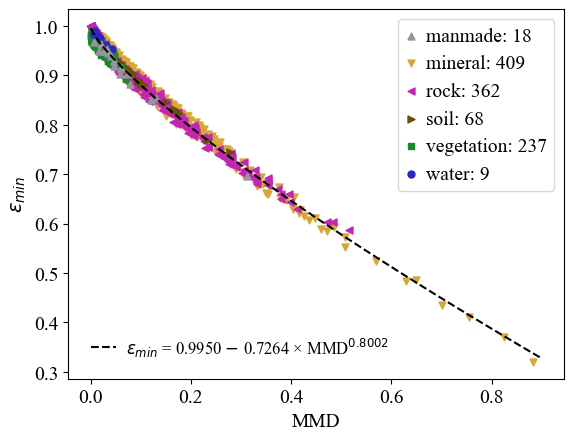

In [7]:
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots()
emin_dic, mmd_dic = {}, {}

colors = ['#99949F', '#D6A839', '#C426B2', '#694E0B', '#1A892B', '#2C26C4']
marker = ['^', 'v', '<', '>', 's', 'o']

xx = np.linspace(0, 0.9, 100)
yy = coefs_mmd[0] - coefs_mmd[1]*np.power(xx, coefs_mmd[2])

for i, lc_i in enumerate(np.unique(lc_valid)):
    emin_dic[lc_i] = emi_min_valid[lc_valid==lc_i]
    mmd_dic[lc_i] = mmd_valid[lc_valid==lc_i]
    if lc_i == 'manmade':
        ax.scatter(mmd_dic[lc_i], emin_dic[lc_i], s=25, c=colors[i], marker=marker[i], label=lc_i+f': {len(emin_dic[lc_i])}', zorder=10)
    else:
        ax.scatter(mmd_dic[lc_i], emin_dic[lc_i], s=25, c=colors[i], marker=marker[i], label=lc_i+f': {len(emin_dic[lc_i])}')

ax.legend(handlelength=0.5, handletextpad=0.5)

ax.plot(xx, yy, 'k--', zorder=20)

ax.set_xlabel('MMD')
ax.set_ylabel('$\\varepsilon_{min}$')

ax.hlines(0.35, 0, 0.05, 'k', '--')
ax.text(0.07, 0.35, f'$\\varepsilon_{{min}}$ = {coefs_mmd[0]:.4f} $-$ {coefs_mmd[1]:.4f} × MMD$^{{{coefs_mmd[2]:.4f}}}$', va='center', ha='left', 
        fontsize=12)

# fig.savefig('figs/emin_mmd.tif', dpi=300, bbox_inches='tight')

# randomly allocate LSE to each profile based on land cover types

In [ ]:
# read land cover of atm profiles
lcc = np.load('data/profile_info/lcc.npy')
num_profile = len(lcc)

'''
lcc:
grassland: 11, 110, 130, 140
shrub: 120, 121, 122
tree: 50-90
tree & shrub: 12, 40, 100
cropland: 10, 20, 30 -> shrub & grass
bare: 200, 201, 202, 150, 151, 152, 153
urban: 190
water: 210, 220, 160, 170, 180
'''
idx_profile = {}
idx_profile['grass'] = np.where(np.isin(lcc, [11, 110, 130, 140]))[0]
idx_profile['shrub'] = np.where(np.isin(lcc, [120, 121, 122]))[0]
idx_profile['tree'] = np.where((lcc>=50) & (lcc<=90))[0]
idx_profile['tree_shrub'] = np.where(np.isin(lcc, [12, 40, 100]))[0]
idx_profile['shrub_grass'] = np.where(np.isin(lcc, [10, 20, 30]))[0] # cropland
idx_profile['bare'] = np.where(np.isin(lcc, [200, 201, 202, 150, 151, 152, 153]))[0]
idx_profile['water'] = np.where(np.isin(lcc, [210, 220, 160, 170, 180]))[0]
idx_profile['urban'] = np.where(lcc==190)[0]
idx_profile['none'] = np.where(lcc==0)[0]

'''
n = 0
for key in idx_profile.keys():
    n += len(idx_profile[key])
    print(f'{key}: {len(idx_profile[key])}')
print(n)
'''

"\nn = 0\nfor key in idx_profile.keys():\n    n += len(idx_profile[key])\n    print(f'{key}: {len(idx_profile[key])}')\nprint(n)\n"

In [12]:
# read ecostress LSE from spectral library
emi_all = np.load('data/spectra_lab/emi_ecostress.npy')
lc = np.load('data/spectra_lab/lc.npy')
lc_subclass = np.load('data/spectra_lab/lc_subclass.npy')

emi_min = np.min(emi_all, axis=1)
ratio = emi_all / np.mean(emi_all, axis=1, keepdims=True)
mmd = np.max(ratio, axis=1) - np.min(ratio, axis=1)

emi_min_prd = coefs_mmd[0] - coefs_mmd[1]*np.power(mmd, coefs_mmd[2])
d_emi = np.abs(emi_min-emi_min_prd)
idx_valid = np.where(d_emi<0.02)[0]
emi_valid, lc_valid, lc_subclass_valid = emi_all[idx_valid, :], lc[idx_valid], lc_subclass[idx_valid]

idx_lab, emi_lab = {}, {}
idx_lab['tree'] = np.where(lc_subclass_valid=='tree')[0]
idx_lab['shrub'] = np.where(lc_subclass_valid=='shrub')[0]
idx_lab['grass'] = np.where(lc_subclass_valid=='grass')[0]
idx_lab['tree_shrub'] = np.where((lc_subclass_valid=='tree') | (lc_subclass_valid=='shrub'))[0]
idx_lab['shrub_grass'] = np.where((lc_subclass_valid=='shrub') | (lc_subclass_valid=='grass'))[0]
idx_lab['water'] = np.where(lc_valid=='water')[0]
idx_lab['bare'] = np.where((lc_valid=='rock') | (lc_valid=='soil'))[0]
idx_lab['urban'] = np.where(lc_valid=='manmade')[0]

for key in idx_lab.keys():
    emi_lab[key] = emi_valid[idx_lab[key], :]
emi_lab['none'] = emi_valid

In [ ]:
# build emissivty for each profile and LST
# array: num_profile * 5 (num_Ts) * 5 (num_sample) * 5 (num_channel)
num_lst, num_lse, num_channel = 5, 5, 5 
emi_simu = np.zeros((num_profile, num_lst, num_lse, num_channel), dtype=np.float32)

np.random.seed(42)
for key in idx_profile.keys():
    idx_key = idx_profile[key]
    emi_key = emi_lab[key]
    num1, num2 = len(idx_key), len(emi_key)
    
    emi_choose_key = np.zeros((num1, num_lst, num_lse, num_channel))
    for i in range(num1):
        for j in range(num_lst):
            idx_rdm = np.random.choice(num2, size=num_lse, replace=False)
            emi_choose_key[i, j, :, :] = emi_key[idx_rdm, :]
    
    emi_simu[idx_key, :, :, :] = emi_choose_key

# np.save('data/profile_info/emi_simu.npy', emi_simu)

# simulate L_toa and L_grd

In [ ]:
lamda_c = np.array([8.29587257, 8.81448846, 9.21205838, 10.49186976, 12.08465478])

with open('data/atm_params/atm_params_true.pkl', 'rb') as f:
    atm_params = pickle.load(f)

emi = emi_simu
Ts = np.load('data/profile_info/skt.npy')[:, 1:]
tau, Lu, Ld = atm_params['tau'], atm_params['Lu'], atm_params['Ld']

In [25]:
# shape: num_atm * num_vza * num_Ts * num_emi * num_ch
Le = Planck_law(Ts[:,:,None], lamda_c) # shape: num_atm * num_Ts * num_ch
Lg = emi * Le[:,:,None,:] + (1-emi) * Ld[:,None,None,:]
Lt = Lg[:,None,...] * tau[:,:,None,None,:] + Lu[:,:,None,None,:]
Lg = np.repeat(Lg[:,None,...], 6, axis=1) # for each vza, Lg is the same

In [ ]:
# save Lg and Lt under clear-sky conditions
idx_clear = np.load('data/profile_info/idx_clear.npy')
np.save('data/simulation_dataset/Lg_simu.npy', Lg[idx_clear])
np.save('data/simulation_dataset/Lt_simu.npy', Lt[idx_clear])
np.save('data/simulation_dataset/emi.npy', emi_simu[idx_clear])